# Week 2 - Polynomial Curve Fitting and Decision Theory

Learning contents:

1. Linear models
    - Linear function
    - Error function
    - Root meant square error
    - Optimization of Error function
    - Test the model
2. Regularization
    - Error function
    - Optimization
    - Test with regularization
3. Model Selection
    - Cross-validation
4. Bayesian curve fitting
    - Display results

## Description

In this exercise we will apply Linear Models for Polynomial Curve Fitting task.

You have to fill empty functions (with pass in body) to match their purpose.

1. You have to create a code for evaluation of a Linear Model, it's error functions and finding optimal weights with given error functions.
2. You need to add regularization to the optimization procedure.
3. You need to implement Cross-validation model selection technique.
4. You need to implement Bayesian curve fitting, computing phi and S matricies at first, then using them to compute mean and variance.

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import exp

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

In [2]:
def target_func(x): return np.sin(2*np.pi*x)

def generate_data(size):
    rng = np.random.RandomState(26052605)
    x_train = rng.uniform(0., 1., size)
    y_train = target_func(x_train) + rng.normal(scale=0.1, size=size)
    x_test = np.linspace(0., 1., 100)
    y_test = target_func(x_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_data(10)

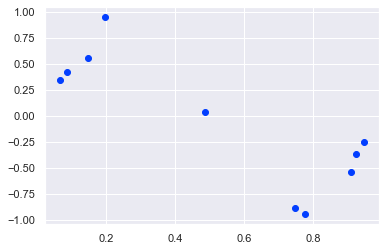

In [3]:
plt.scatter(x_train, y_train)

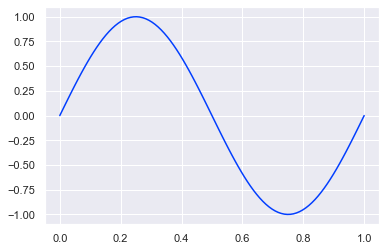

In [4]:
plt.plot(x_test, y_test, '-')

## 1) Linear models

### 1.1) Linear function

`linear` takes data point `x` and a list of `weights` as parameters 

In [5]:
def linear(x, weights):
    terms = [(x**exponent * weight) for exponent, weight in enumerate(weights)]
    y = sum(terms)
    return y

### 1.2) Error function

`err` is a sum-of-squares error function that takes `weights`, `inputs` and `targets` as parameters

In [6]:
def err(weights, inputs, targets):
    pairs = zip(inputs, targets)
    errors = [(linear(x, weights) - t)**2 for x, t in pairs]
    sum_of_squares = 0.5 * sum(errors)
    return sum_of_squares

### 1.3) Root meant square error

In [7]:
def erms(weights, inputs, targets):
    root_mse = np.sqrt(2*err(weights, inputs, targets)/len(inputs))
    return root_mse

### 1.4) Optimization of Error function

`optimial_weights` takes `inputs`, `targets`, and `M` (number of weights) as parameters and returns optimal weights for this data

In [16]:
def optimial_weights(inputs, targets, M):
    M_iter = range(M + 1)
    X_matrix = np.zeros((M+1, len(inputs)))
    for j, input_i in enumerate(inputs):
        x_j = np.array([input_i**order for order in M_iter])
        X_matrix[:,j] += x_j
    w_star = np.linalg.inv(X_matrix @ X_matrix.T) @ X_matrix @ targets
    return w_star

### 1.5) Test the model

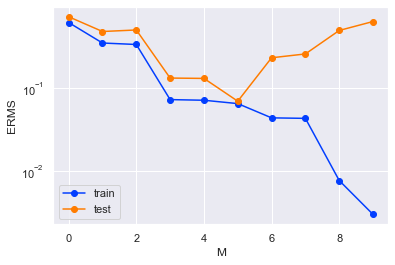

In [17]:
def test_all(start_M, end_M, x_train, y_train, x_test, y_test):
    
    results_train = []
    results_test = []
    all_weights = []
    
    for M in range(start_M, end_M + 1):
        weights = optimial_weights(x_train, y_train, M)
        all_weights.append(weights)
        error_train = erms(weights, x_train, y_train)
        error_test = erms(weights, x_test, y_test)
        results_train.append(error_train)
        results_test.append(error_test)
    return results_train, results_test, all_weights

r_tr, r_tt, all_weights = test_all(0, 9, x_train, y_train, x_test, y_test)

plt.plot(list(range(0, 10)), r_tr, '-o', label='train')
plt.plot(list(range(0, 10)), r_tt, '-o', label='test')
plt.xlabel('M')
plt.ylabel('ERMS')
plt.legend()
plt.yscale('log')

##### Weights table for different `M`

In [10]:
print(pd.DataFrame(all_weights))

          0           1            2             3             4  \
0 -0.067444         NaN          NaN           NaN           NaN   
1  0.674906   -1.403250          NaN           NaN           NaN   
2  0.870601   -2.937208     1.521622           NaN           NaN   
3 -0.348533   11.654727   -33.094539     22.088529           NaN   
4 -0.274931   10.447965   -27.877273     14.161034      3.897826   
5  0.052313    2.957062    24.077616   -126.364848    164.359000   
6  1.343704  -29.263453   282.780684  -1019.109757   1661.058929   
7  1.660040  -39.467240   401.669104  -1667.843884   3460.330163   
8 -2.483715  104.734625 -1467.542517  10143.393781 -36837.934077   
9 -1.496608   61.141606  -713.285487   3474.935592  -3725.985532   

              5             6              7             8             9  
0           NaN           NaN            NaN           NaN           NaN  
1           NaN           NaN            NaN           NaN           NaN  
2           NaN           

##### Estimated curve for `M=9` (same as the amount of data points) 

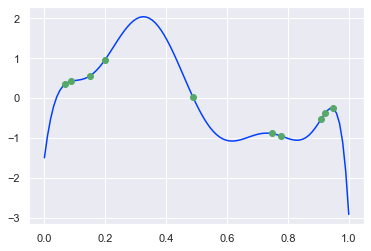

In [11]:
plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights(x_train, y_train, 9)), x_test)), '-')
plt.plot(x_train, y_train, 'og')

## 2) Regularization

### 2.1) Error function

`err_regularization` takes `weights`, `inputs`, `targets` and `l` (regularization term) and computes sum-of-squares error with weights regularization

In [12]:
def err_regularization(weights, inputs, targets, l):
    pairs = zip(inputs, targets)
    errors = [(linear(x, weights) - t)**2 + 0.5*l*np.linalg.norm(weights) for x, t in pairs]
    sum_of_squares = 0.5 * sum(errors)
    return sum_of_squares

`erms_regularization` is a regularization version of a root mean squares error

In [13]:
def erms_regularization(weights, inputs, targets, l):
    root_mse = np.sqrt(2*err_regularization(weights, inputs, targets, l)/len(inputs))
    return root_mse

### 2.2) Optimization

`optimial_weights_regularization` takes `inputs`, `targets`, `M` (number of weights) and `l` (regularization term)  as parameters and returns optimal weights (with regularization) for this data

In [39]:
def optimial_weights_regularization(inputs, targets, M, l):
    A = np.zeros((M+1, M+1))
    for i in range(M+1):
        for j in range(M+1):
            A[i,j] += sum([input_n**(i+j) for input_n in inputs])
    A += l * np.eye(M+1)

    # why doesn't this work
#     x_t_pairs = zip(inputs, targets)
#     T = np.zeros(M+1)
#     for i in range(len(T)):
#         T[i] += sum([x_n**i*t_n for (x_n, t_n) in x_t_pairs])
    # alternative
    T = np.zeros(M+1)
    for i in range(M+1):
        T[i] += sum([inputs[a]**i*targets[a] for a in range(len(targets))])

    return np.linalg.solve(A, T)

### 2.3) Test with regularization

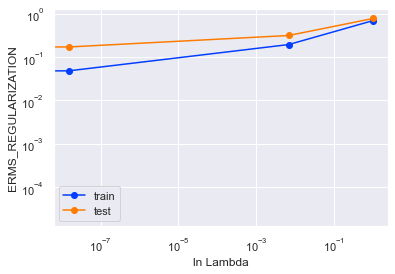

In [40]:
def test_all_regularization(ls, M, x_train, y_train, x_test, y_test):
    
    results_train = []
    results_test = []
    all_weights = []
    
    for l in ls:
        weights = optimial_weights_regularization(x_train, y_train, M, l)
        all_weights.append(weights)
        error_train = erms_regularization(weights, x_train, y_train, l)
        error_test = erms_regularization(weights, x_test, y_test, l)
        results_train.append(error_train)
        results_test.append(error_test)
    return results_train, results_test, all_weights

ls = [0, exp(-18), exp(-5), exp(0)]

r_tr_r, r_tt_r, all_weights_r = test_all_regularization(ls, 9, x_train, y_train, x_test, y_test)

plt.plot(ls, r_tr_r, '-o', label='train')
plt.plot(ls, r_tt_r, '-o', label='test')
plt.xlabel('ln Lambda')
plt.ylabel('ERMS_REGULARIZATION')
plt.legend()
plt.yscale('log')
plt.xscale('log')

##### Weights for `M=9` with regularization terms `0`, `exp(-18)`, `exp(-5)`, `exp(0)`

In [22]:
print(pd.DataFrame(np.transpose(all_weights_r)))

               0              1              2             3
0      -1.496608      -1.514937      -1.510822     -0.289109
1      61.141606      62.039502      62.492670     67.698377
2    -713.285487    -728.646558    -736.152050   -825.801959
3    3474.935592    3609.263250    3674.903500   4459.740140
4   -3725.985532   -4388.218082   -4711.566873  -8576.558742
5  -21932.647471  -20017.502331  -19082.843901  -7918.581292
6   82350.631370   79049.928654   77439.554944  58215.658288
7 -118280.176972 -114950.564164 -113326.440985 -93947.192694
8   79638.392834   77825.321831   76941.074799  66393.761461
9  -20874.425856  -20462.991181  -20262.354145 -17869.791666


In [23]:
def plot_by_lambda(l):
    plt.plot(x_test, y_test, '-m')
    plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights_regularization(x_train, y_train, 9, l)), x_test)), '-')
    plt.plot(x_train, y_train, 'og')

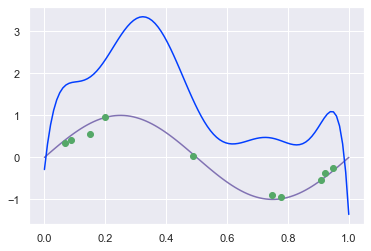

In [24]:
plot_by_lambda(exp(0))

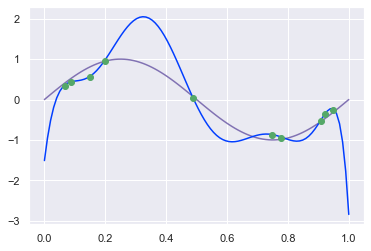

In [25]:
plot_by_lambda(exp(-5))

In [ ]:
plot_by_lambda(exp(-18))

In [ ]:
plot_by_lambda(0)

## 3) Model Selection

### 3.1) Cross-validation

`create_cross_validation_sets` takes `S` (number of sets) and data points `x_train`, `y_train` as parameters and returns array of sets in form `[x_sub_train, y_sub_train, x_validation, y_validation]` each

In [41]:
def create_cross_validation_sets(S, x_train, y_train):
    index = int(len(x_train)/S)
    array = []
    
    for i in range(S):
        array.append([list(x_train[:i*index])+list(x_train[(i+1)*index:]), 
                       list(y_train[:i*index])+list(y_train[(i+1)*index:]), 
                       x_train[i*index:(i+1)*index], 
                       y_train[i*index:(i+1)*index]])
    return array

`best_model` takes `start_M`, `end_M` (low and high limits to search for `M`), `ls` (list of regularization terms) and `sets` (cross-validation sets) and should return `(top_M, top_l, top_result_test)` with `M`, `l` and result for the best model

M = 5 lambda = 0 erms = 0.10643616094268163


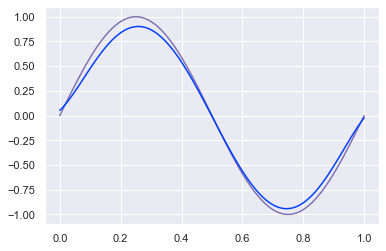

In [42]:
def best_model(start_M, end_M, ls, sets):
    best = []
    for m in range(start_M, end_M+1):
        for l in ls:
            tmp = []
            for sub in sets:
                w = optimial_weights_regularization(sub[0], sub[1], m, l)
                tmp.append(erms_regularization(w, sub[2], sub[3], l))
            best.append([m, l, np.mean(tmp)])
    return best[np.argmin([model[-1] for model in best])]

x_cross_train, y_cross_train, _, _ = generate_data(100) 

M, l, r = best_model(0, 9, [0, exp(-18), exp(-5), exp(0)], create_cross_validation_sets(10, x_cross_train, y_cross_train))
print('M =', M, 'lambda =', l, 'erms =', r)

plt.plot(x_test, y_test, '-m')
plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights_regularization(x_train, y_train, M, l)), x_test)), '-')

## 4) Bayesian curve fitting

`phi` takes `x` (data point) and `M` (number of weights) as arguments and returns a vector of powers of `x` from `0` to `M`<br>
<i>Functions S, mean and variance are defined using definitions from slide 22 of lecture 3</i>

In [63]:
def phi(x, M):
    return np.array([x**M_i for M_i in range(M+1)]).T

`S` takes `alpha`, `beta`, `x` (all data points), and `M` as arguments and returns a matrix `S` that is used to compute `mean` and `variance`

In [68]:
def S(alpha, beta, x, M):
    S_inv = alpha*np.eye(M+1) + beta*sum(np.outer(phi(b, M), phi(b,M)) for b in x)
    return np.linalg.inv(S_inv)

`mean` takes `alpha`, `beta`, `x_star` (new point), `x` (all data points), `t` (target values), and `M` and computes mean for the Gaussian distribution

In [65]:
def mean(alpha, beta, x_star, x, t, M):
    return beta*phi(x_star, M).T @ S(alpha, beta, x, M) @ sum([phi(x[i], M)*t[i] for i in range(len(t))])

`variance` takes `alpha`, `beta`, `x_star` (new point), `x` (all data points), `t` (target values), and `M` and computes variance for the Gaussian variance

In [66]:
def variance(alpha, beta, x_star, x, t, M):
    return 1/beta + phi(x_star, M)@S(alpha, beta, x, M)@phi(x_star, M).T

### 4.1) Display results

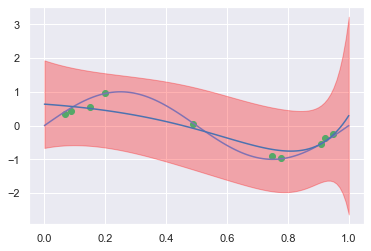

In [67]:
alpha = 0.05
beta = 1.1
M = 9

means = np.array(list(map(lambda x: mean(alpha, beta, x, x_train, y_train, M), x_test)))
variances = np.array(list(map(lambda x: variance(alpha, beta, x, x_train, y_train, M), x_test)))

plt.plot(x_train, y_train, 'og')
plt.plot(x_test, y_test, '-m')
plt.plot(x_test, means, '-b')
plt.fill_between(x_test, means + variances, means - variances, color='red', alpha=0.3)